In [1]:
import pandas as pd
import json
import networkx as nx
import ast
import community

def load_network_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        G = nx.node_link_graph(data)
    return G

file_path = 'data/network_with_attributes.json'
G = load_network_from_json(file_path)


network_df = pd.read_csv('data/df_clean_data_with_comm.csv', sep=';', names = ['prod_id','prod','pris/stk','link','catagory','pris','mængde','overkatagori','naboer','description','d_length','ecology','Pairs','community','degree'])

***The closness centrality***

In [2]:
centrality_of_G = nx.closeness_centrality(G)

In [50]:

sorted_closeness = sorted(centrality_of_G.items(), key=lambda item: item[1], reverse=True)
top15_closeness = []
for p_id, value in sorted_closeness[:15]:
    top15_closeness.append(network_df[network_df["prod_id"]==p_id])
top15_closeness[0]['naboer']

268    [18323, 18381, 18518, 19643, 19721, 51061, 533...
Name: naboer, dtype: object

In [54]:
import ast
bridge_dict_closeness = dict()
for node in top15_closeness:
    bridge_dict_closeness[str(node['prod'].tolist()[0])] = set()
    for naboer in node['naboer'].apply(ast.literal_eval):
        for nabo in naboer:
            
            bridge_dict_closeness[str(node['prod'].tolist()[0])].add(network_df[network_df["prod_id"]==nabo]['community'].tolist()[0])
bridge_dict_closeness

{'agurk': {0.0},
 'agurk øko': {0.0, 2.0},
 'finvalsede havregryn øko': {0.0, 2.0},
 'æg m/l øko': {0.0, 2.0},
 'smørbar': {0.0},
 'hvedemel øko': {0.0, 2.0},
 'hakkede tomater øko': {0.0, 2.0},
 'bananer 4 pak øko': {0.0, 2.0},
 'skrabeæg m/l': {0.0},
 'rosiner øko': {0.0, 2.0},
 'peberfrugter røde': {0.0},
 'bananer': {0.0},
 'remoulade øko': {2.0},
 'mørk pålægschokolade 53% kakao øko': {2.0, 17.0}}

***Betweenness centrality***

In [5]:
betweenness_of_G = nx.betweenness_centrality(G)

In [20]:
sorted_betweenness = sorted(betweenness_of_G.items(), key=lambda item: item[1], reverse=True)
top15 = []
for p_id, value in sorted_betweenness[:15]:
    top15.append(network_df[network_df["prod_id"]==p_id])
top15[0]['naboer']

268    [18323, 18381, 18518, 19643, 19721, 51061, 533...
Name: naboer, dtype: object

In [61]:
import ast
bridge_dict = dict()
for node in top15:
    bridge_dict[str(node['prod'].tolist()[0])] = set()
    for naboer in node['naboer'].apply(ast.literal_eval):
        for nabo in naboer:
            
            bridge_dict[str(node['prod'].tolist()[0])].add(network_df[network_df["prod_id"]==nabo]['community'].tolist()[0])
         
            #print(network_df[network_df["prod_id"]==nabo]['community'])
bridge_dict
            

{'agurk': {0.0},
 'smørbar': {0.0},
 'mørk pålægschokolade 53% kakao øko': {2.0, 17.0},
 'agurk øko': {0.0, 2.0},
 'æg m/l øko': {0.0, 2.0},
 'finvalsede havregryn øko': {0.0, 2.0},
 'skrabeæg m/l': {0.0},
 'remoulade øko': {2.0},
 'hvedemel øko': {0.0, 2.0},
 'bananer': {0.0},
 'hakkede tomater øko': {0.0, 2.0},
 'bananer 4 pak øko': {0.0, 2.0},
 'peberfrugter røde': {0.0},
 'tonic': {2.0, 4.0, 10.0}}

In [65]:
set(bridge_dict.keys())-set(bridge_dict_closeness.keys())
#network_df[network_df["prod_id"]==nabo]['community']


{'tonic'}

Number of communities: 25
Sizes of communities: [1715, 1510, 1083, 55, 907, 371, 63, 175, 103, 498, 276, 213, 730, 381, 170, 198, 160, 97, 279, 115, 20, 180, 76, 152, 228]


Text(0.5, 1.0, 'Foods-network')

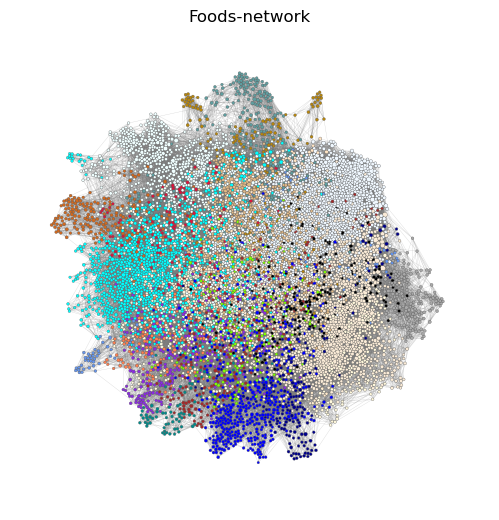

In [64]:
import community
# Find communities using the Louvain algorithm
louvrain_partition = community.best_partition(G)
sorted_communities = dict(sorted(louvrain_partition.items(), key=lambda item: item[1], reverse=True))

# Compute modularity
#modularity_louvain = community.modularity(sorted_communities, G)

# Print modularity values
print("Number of communities:", len(set(sorted_communities.values())))
print("Sizes of communities:", [list(sorted_communities.values()).count(x) for x in set(sorted_communities.values())])
#print("Modularity by Louvain algorithm:", modularity_louvain)

#og så gemmer jeg deres communities i den stores Json-fil med:

nx.set_node_attributes(G, sorted_communities, name='community')

# Save the updated graph with community information to a new JSON file
# output_file_path = '/Users/KAROLINE/Desktop/comsocsci2024/lectures/network_with_attributes_and_communities.json'
# data = nx.readwrite.json_graph.node_link_data(G)
# with open(output_file_path, 'w') as f:
#     json.dump(data, f)

#men ved ikke om det er helt rigtigt… bruger kris funktion til at tegne det:

import matplotlib.colors as mcolors
from netwulf import visualize, draw_netwulf

colors = list(mcolors.CSS4_COLORS.keys())
n_colors = len(colors) 

community_colors = {community: colors[i % n_colors] for i, community in enumerate(set(sorted_communities.values()))}

for idx, (node, commun) in enumerate(sorted_communities.items()):
    G.nodes[node]['color'] = community_colors[commun]
   


network, _ = visualize(G)
fig, ax = draw_netwulf(network)
ax.set_title('Foods-network')

In [10]:
sorted_communities

{94389: 24,
 124362: 24,
 111051: 24,
 87990: 24,
 85700: 24,
 81836: 24,
 73910: 24,
 73908: 24,
 73903: 24,
 73557: 24,
 57836: 24,
 82210: 24,
 87442: 24,
 52132: 24,
 65271: 24,
 73911: 24,
 82209: 24,
 70476: 24,
 129769: 24,
 62335: 24,
 56980: 24,
 39419: 24,
 14638: 24,
 129770: 24,
 124341: 24,
 85861: 24,
 19865: 24,
 118597: 24,
 87989: 24,
 73913: 24,
 81833: 24,
 14645: 24,
 14642: 24,
 14798: 24,
 81834: 24,
 111052: 24,
 79277: 24,
 64221: 24,
 52131: 24,
 62200: 24,
 42683: 24,
 14787: 24,
 87443: 24,
 129625: 24,
 72071: 24,
 73902: 24,
 59377: 24,
 73901: 24,
 92083: 23,
 77936: 23,
 56258: 23,
 56257: 23,
 55746: 23,
 21287: 23,
 21273: 23,
 21211: 23,
 21208: 23,
 21286: 23,
 92085: 23,
 128307: 23,
 110143: 23,
 39538: 23,
 110127: 23,
 64229: 23,
 14679: 23,
 110139: 23,
 56256: 23,
 128420: 23,
 104694: 23,
 77944: 23,
 77939: 23,
 125872: 23,
 104981: 23,
 110147: 23,
 110137: 23,
 110148: 23,
 110144: 23,
 77941: 23,
 55783: 23,
 110128: 23,
 64225: 23,
 110130